### Final Project Foundamentals of Data Science
## Solar Eclipse phases classification
#### Luca Moresca, Nicholas Suozzi, Valerio Santini

---------



In [263]:
if True:
    %pip install -qqq numpy scipy matplotlib pandas scikit-learn seaborn tqdm efficientnet_pytorch

Note: you may need to restart the kernel to use updated packages.


In [264]:
%matplotlib inline
import os
import json
import time
import cv2
import random
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import convolve1d
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from typing import List, Tuple, Optional, Dict, Union
from concurrent.futures import ThreadPoolExecutor
from PIL import Image, UnidentifiedImageError
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
# Usefull for histograms, taken from homework 1

def rgb2gray(rgb: np.ndarray) -> np.ndarray:
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def plot_pictures(
    imgs: List[np.ndarray],
    xlabels: List[str],
    nrows: int,
    ncols: int,
    show: bool = True,
    cmap: Union[str, List[str]] = "gray",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    same_scale: bool = False,
) -> List[plt.Axes]:
    fig, axs = plt.subplots(nrows, ncols,
                            width_ratios=[img.shape[1] / img.shape[0] for img in imgs],
                            sharey=same_scale,
                            figsize=(ncols * 4, nrows * 4))
    axs = axs.flatten()

    for i, (img, ax) in enumerate(zip(imgs, axs)):
        if isinstance(cmap, list):
            current_cmap = cmap[i]
        else:
            current_cmap = cmap
        im = ax.imshow(img, cmap=current_cmap, vmin=vmin, vmax=vmax)


        ax.set_title(xlabels[i])
        ax.axis('off')
    plt.tight_layout()

    if show:
        plt.show()
    else:
        return axs

## 1. Dataset Analysis

The “Great American Eclipse” in 2017 offered a unique opportunity for US citizens across the entire continent to experience the awe-inspiring changes that occur during rare total solar eclipses (TSEs). The goal of the 2017 Eclipse Megamovie was to obtain enough pictures of the Great American Total Solar Eclipse to create a movie of the solar corona in order to better study it. Over 2,000 volunteers submitted 50,000 images and a movie was made only a few hours after the Moon's shadow left the U.S. A few months later another, better aligned and more closely edited, movie was released. The Eclipse Megamovie team of scientists processed images to create High Dynamic Range (HDR) images to capture the structures within the high dynamic range of the solar corona from the Sun's photosphere out ~3 solar radii.
https://eclipsemegamovie.org

Eclipse megamovie is a project being carried out by a group of researchers in collaboration with NASA. The focus of this project is to make a video that can facilitate research into a rare event such as the eclipse that occurred in the United States in 2017. To realise this project, American citizens were asked to send in photographs taken during the eclipse. The dataset therefore contains semi-professional and amateur images, taken under conditions that are not always optimal.

In [266]:
with open('eclipse-megamovie/label_num_to_phase_map.json', 'r') as file:
    data = json.load(file)
print(json.dumps(data, indent=4))

{
    "TotalSolarEclipse": 0,
    "0to25percentPartialEclipse": 1,
    "26to55percentPartialEclipse": 2,
    "56to95percentPartialEclipse": 3,
    "Darks": 4,
    "DiamondRing_BaileysBeads_SolarEclipse": 5,
    "Flats": 6,
    "NotASolarEclipse": 7
}


In [267]:
df = pd.read_csv("eclipse-megamovie/train.csv")
print(df)

                                              image_id  label
0    0089d49c892b6d15513690521c08eb5ffc93fe24a4926c...      0
1    00ade9976af2090eae8e6e5eed3096f12dc7235adb3c12...      0
2    ff6c7fea709fd7bbb1790668dc664b30ed72cfb2cae0a0...      0
3    eee7f9abf29297179aa070518671bfc9a60c9f8a67e62a...      0
4    fcc12656dacc1867bbea8438635bf52b4b1920cac3e48b...      0
..                                                 ...    ...
490  4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba...      7
491  fb9026a6d96719729ef44c61e76c5b007b17784f6ddb8f...      7
492  0160498b80fcf8f55002627f1f3eb7c6969675f7877410...      7
493  021c7d3386821090186bd925a8d13d9cc509db69550956...      7
494  018b72bf1ef4f3a184c0029ffcff3dde17f4a883ef472f...      7

[495 rows x 2 columns]


The .json file relates the eclipse phases to the corresponding labels in the ‘train.csv’ file, which will help the training phase by already having a correspondence between label and image. The csv file then contains a classification of the various training images useful for the model. 

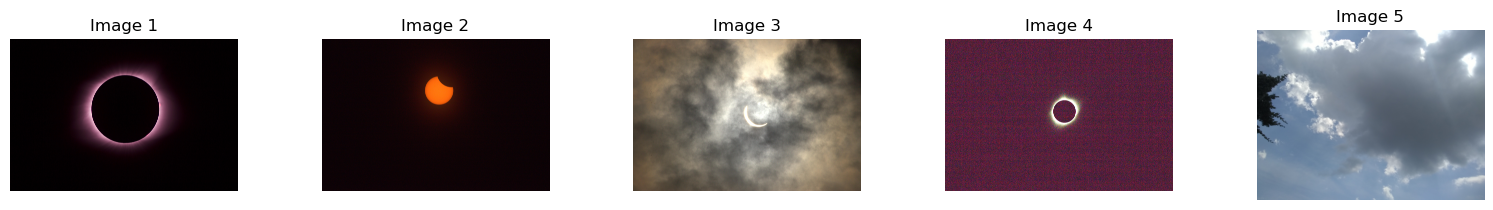

In [268]:
img1 = mpimg.imread('eclipse-megamovie/train/00a0f91f0e7ece88ebaeab2a2050cdc0d72c5ea0b56c601dfaf800077df44c51.jpg')
img2 = mpimg.imread('eclipse-megamovie/train/00a4af4cc3f2a667c80331051a733e8dae2477d682d7dcef3e895f6f923dd86a.jpg')
img3 = mpimg.imread('eclipse-megamovie/train/00c11b16fd6426a88039c8b27e2511e2e770b65e0eb9daab720d3e6ca996bc06.jpg')
img4 = mpimg.imread('eclipse-megamovie/train/001e6704a60798684f1656713b593e6a56de81474e7173a31936589cd62f13e8.jpg')
img5 = mpimg.imread('eclipse-megamovie/train/4f99a8e1efe0a51fca127bcdabfb1165523dee8730dbba0df5436a7de70dc16e.jpg')

fig, axes = plt.subplots(1, 5, figsize=(16, 4))
fig.tight_layout(pad=3.0)

axes[0].imshow(img1)
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title("Image 2")
axes[1].axis('off')

axes[2].imshow(img3)
axes[2].set_title("Image 3")
axes[2].axis('off')

axes[3].imshow(img4)
axes[3].set_title("Image 4")
axes[3].axis('off')

axes[4].imshow(img5)
axes[4].set_title("Image 5")
axes[4].axis('off')

plt.show()

* As can be seen in the figure above, our dataset consists of various types of images. Some contain eclipses, others do not. The images have different perspectives, are taken with different devices and have different backgrounds. 
This presents us with the challenge of correctly identifying the content of each image accurately, we must be able to classify images that do not contain eclipses as impostors. 
On a numerical level, the dataset consists of a training set and a test set. In addition, there is a .csv file containing the name of some images and a label showing the corresponding eclipse phase. In addition, there is a .json file that explains what each label corresponds to on a phase level. 
There are 496 images in the training set and 140 images in the test set. The dataset is restricted and this will result in an appropriate treatment of the images to improve the performance of the model. 

* Each image has a different resolution, considering that they are obtained with various devices. The eclipse within each image is not always perfectly sharp or centred, making the model more elastic in various cases.


## Pre-processing

### Greyscale conversion 

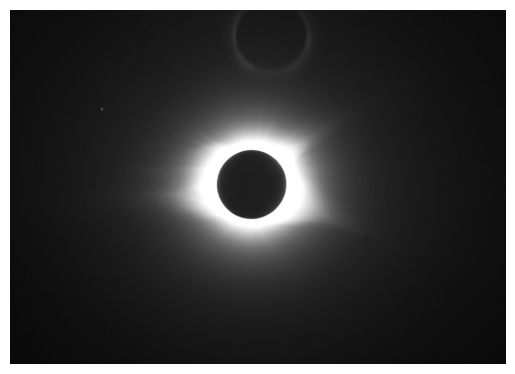

In [269]:
path = "eclipse-megamovie/train/00a8e42aff446cd530533d7f45a92c28c2880c4576f9fb6869b768dfb0109942.jpg"
image = cv2.imread(path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, cmap="gray")
plt.axis('off')
plt.show()

### Denoising

A denoising process is performed, applying a Gaussian filter by convolution to the image.

In [270]:
def gauss(sigma: float, filter_size: int) -> Tuple[np.ndarray, np.ndarray]:
    Gx = np.array([])
    k = (filter_size - 1) // 2  
    x = np.arange(-k, k + 1)
    cost = 1/(np.sqrt(2*np.pi)*sigma)
    Gx = np.append(Gx, cost * np.exp(-(x**2)/(2*sigma**2)))
    return Gx, x

def gaussfiltering(img: np.ndarray, sigma: float) -> np.ndarray:
    filter_size = np.round(6 * sigma)

    Gx, _ = gauss(sigma, filter_size)
    out = convolve1d(img, Gx, axis = 1)
    out = convolve1d(out, Gx, axis = 0)
    
    return out

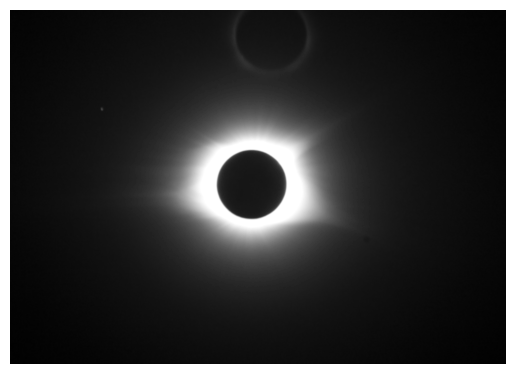

In [271]:
sigma = 3

smt_img = gaussfiltering(gray_image, sigma)

plt.imshow(smt_img, cmap="gray")
plt.axis('off')
plt.show()

### Normalization
The normalize function performs linear normalization of an image to scale pixel values in the range $[0,1]$

In [272]:
def normalize(img):
    return (img - img.min()) / (img.max() - img.min())

In [273]:
nrm_img = normalize(smt_img)

### Eclipse Isolation

This function identifies and isolates the brightest region of an image by performing a square crop centered on it. It uses Otsu's threshold method to determine the brightest pixels and then identifies the largest connected region using regionprops. After calculating an extended bounding box with an offset, it determines a square crop based on the longest side of the detected area, centering the crop on the bright region.

If the crop exceeds the boundaries of the image, the edges are corrected to keep the crop within the image itself. In the absence of bright regions, the function returns None.

In [274]:
def detect_eclipse(image):
    offset = 128
    intensity_threshold = threshold_otsu(image)
    bright_pixels = image > intensity_threshold

    labeled_bright = label(bright_pixels)
    regions = regionprops(labeled_bright)
    
    if len(regions) == 0:
        print("No light regions detected.")
        return None
    largest_region = max(regions, key=lambda r: r.area)
    minr, minc, maxr, maxc = largest_region.bbox

    height = maxr - minr + offset
    width = maxc - minc + offset
    
    side_length = max(height, width)

    center_r = (minr + maxr) // 2
    center_c = (minc + maxc) // 2

    minr = center_r - side_length // 2
    maxr = center_r + side_length // 2
    minc = center_c - side_length // 2
    maxc = center_c + side_length // 2
    
    if minr < 0:
        maxr += abs(minr)  
        minr = 0
    if maxr > image.shape[0]:
        minr -= maxr - image.shape[0]
        maxr = image.shape[0]

    if minc < 0:
        maxc += abs(minc)   
        minc = 0
    if maxc > image.shape[1]:
        minc -= maxc - image.shape[1]
        maxc = image.shape[1]

    minr = max(0, minr)
    minc = max(0, minc)
    maxr = min(image.shape[0], maxr)
    maxc = min(image.shape[1], maxc)

    cropped_image = image[minr:maxr, minc:maxc]

    return cropped_image

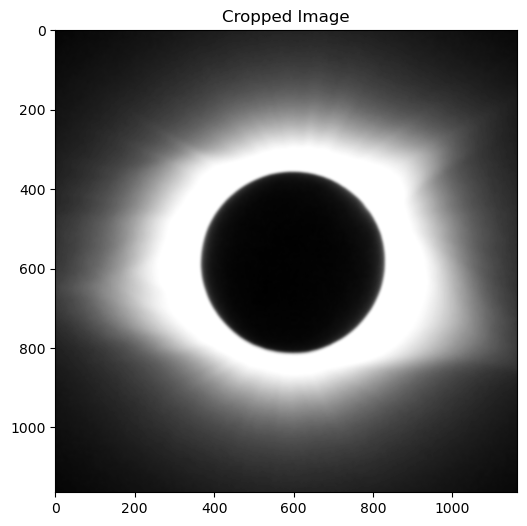

In [275]:
cropped_img = detect_eclipse(nrm_img)

#Print Cropped Img
plt.figure(figsize=(12, 6))
plt.title("Cropped Image")
plt.imshow(cropped_img, cmap='gray')
plt.show()


### Downscaling

The downscale function downscales an image to a specified target resolution, applying Gaussian pre-filtering to reduce artifacts due to sampling.

The processe of downscale is: 
* Accepts an input image (img) and an optional target resolution parameter (target_resolution, default (512, 512)).
* Applies Gaussian filtering (gaussfiltering) to smooth the image before resizing.
* Uses skimage.transform.resize to resize the image, with anti_aliasing option to preserve visual quality.
* Converts filtered and resized images to 8-bit (uint8) format to ensure compatibility and optimize memory.

In [276]:
def downscale(
    img: np.ndarray,
    target_resolution: tuple = (512, 512),
    sigma: float = 1
) -> np.ndarray:

    if img.ndim == 3:   
        img_blurred = np.zeros_like(img)
        for c in range(3):
            img_blurred[:, :, c] = gaussfiltering(img[:, :, c], sigma)
    else:   
        img_blurred = gaussfiltering(img, sigma)

    downscaled_img = resize(img_blurred, target_resolution, anti_aliasing=True)

    if img.ndim == 3:  
        downscaled_img = np.clip(downscaled_img * 255, 0, 255).astype(np.uint8)
        img_blurred = np.clip(img_blurred * 255, 0, 255).astype(np.uint8)

    return downscaled_img


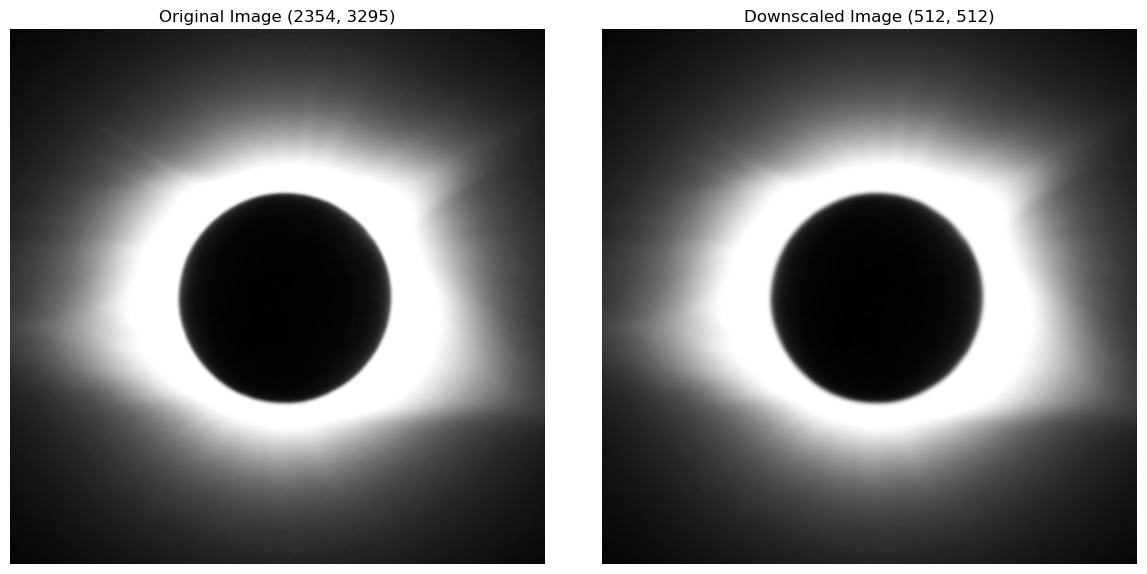

In [277]:
downscaled = downscale(cropped_img, target_resolution=(512, 512), sigma=3)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
plt.gray()
fig.tight_layout()

axes[0].imshow(cropped_img)
axes[0].set_title(f"Original Image {smt_img.shape}")
axes[0].axis('off')
axes[1].imshow(downscaled)
axes[1].set_title(f"Downscaled Image {downscaled.shape}")
axes[1].axis('off')

plt.show()

### Pre-process pipeline function

In [278]:
def preprocess_image(path: str, target_resolution: tuple = (512, 512), sigma: float = 3, offset: int = 128):
    image = cv2.imread(path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    smt_img = gaussfiltering(gray_image, sigma)
    nrm_img = normalize(smt_img)
    cropped_img = detect_eclipse(nrm_img)
    downscaled_img = downscale(cropped_img, target_resolution, sigma)
    downscaled_img *= 255
    return downscaled_img

### Parallelisation of the process

The ThreadPoolExecutor class is part of the Python standard library. It offers easy-to-use pools of worker threads via the modern executor design pattern. It is ideal for making loops of I/O-bound tasks concurrent and for issuing tasks asynchronously. [https://superfastpython.com/threadpoolexecutor-in-python/]

By applying the ThreadPoolExecutor class to the pre-processing phase, we were able to significantly reduce the execution time of the pipeline.

* Time with parallelisation: 97.14 seconds (1.6 minutes)
* Time without parallelisation: 379.42 seconds (6.31 minutes)

In [279]:
def get_image_paths(folder_path):
    supported_formats = ('.jpg', '.png')
    return [
        os.path.join(folder_path, filename)
        for filename in os.listdir(folder_path)
        if filename.lower().endswith(supported_formats)
    ]

def preprocess_images_in_parallel(folder_path, output_folder, target_resolution=(512, 512), sigma=3, num_workers=4):
    image_paths = get_image_paths(folder_path)

    def process_and_save(path):
        try:
            preprocessed_image = preprocess_image(path, target_resolution, sigma)
            if preprocessed_image is None:
                print(f"Error in image preprocessing: {path}")
                return
            
            output_path = os.path.join(output_folder, os.path.basename(path))
            success = cv2.imwrite(output_path, preprocessed_image)
            if not success:
                print(f"Error saving image: {output_path}")
        except Exception as e:
            print(f"Error during processing of {path}: {e}")

    os.makedirs(output_folder, exist_ok=True)
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        executor.map(process_and_save, image_paths)
        
        
def preprocess_images_sequentially(folder_path, output_folder, target_resolution=(512, 512), sigma=3):
    image_paths = get_image_paths(folder_path)
    os.makedirs(output_folder, exist_ok=True)
    for path in image_paths:
        try:
            preprocessed_image = preprocess_image(path, target_resolution, sigma)            
            if preprocessed_image is None:
                print(f"Error in image preprocessing: {path}")
                continue
            output_path = os.path.join(output_folder, os.path.basename(path))
            success = cv2.imwrite(output_path, preprocessed_image)
            if not success:
                print(f"Error saving image: {output_path}")
        except Exception as e:
            print(f"Error during processing of {path}: {e}")

In [280]:
input_folder_train = "eclipse-megamovie/train"
output_folder_train = "train_preprocessed"
input_folder_test = "eclipse-megamovie/test"
output_folder_test = "test_preprocessed"

target_resolution = (512, 512)
sigma = 3

# Training set parallel preprocessing
print(f"Start preprocessing for training set...")
start_time = time.time()
preprocess_images_in_parallel(input_folder_train, output_folder_train, target_resolution, sigma, num_workers=8)
print(f"Preprocessing of training set completed. Images saved in {output_folder_train}.")
print(f"Time with parallelisation: {time.time() - start_time:.2f} seconds")

# Training set sequential preprocessing, deliberately left commented to avoid long running times
# start_time = time.time()
# preprocess_images_sequentially(input_folder_train, output_folder_train, target_resolution, sigma)
# print(f"Tempo senza parallelizzazione: {time.time() - start_time:.2f} secondi")

# Test set parallel
print(f"Start preprocessing for test set...")
preprocess_images_in_parallel(input_folder_test, output_folder_test, target_resolution, sigma, num_workers=8)
print(f"Preprocessing of test set completed. Images saved in {output_folder_test}.")


Start preprocessing for training set...


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


Preprocessing of training set completed. Images saved in train_preprocessed.
Time with parallelisation: 229.84 seconds
Start preprocessing for test set...
Preprocessing of test set completed. Images saved in test_preprocessed.


## Convolutional Neural Network 

### Dataset class

In [281]:
class SolarEclipseDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.target_resolution = target_resolution
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, self.target_resolution)
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

csv_file = "eclipse-megamovie/train.csv"
image_folder = "train_preprocessed/"
dataset = SolarEclipseDataset(csv_file, image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Model class

In [282]:
class SolarEclipseCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SolarEclipseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [283]:
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SolarEclipseCNN(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")
print("Training completed.")

Epoch [1/7], Loss: 2.2916
Epoch [2/7], Loss: 0.9924
Epoch [3/7], Loss: 0.7828
Epoch [4/7], Loss: 0.6550
Epoch [5/7], Loss: 0.5143
Epoch [6/7], Loss: 0.3441
Epoch [7/7], Loss: 0.2567
Training completed.


In [284]:
# Save the trained model 
model_path = "eclipse-megamovie/solar_net.pth"
torch.save(model.state_dict(), model_path)

In [285]:
# model.load_state_dict(torch.load(model_path, weights_only=True))

### Classification report

In [286]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       187
           1       0.98      1.00      0.99        52
           2       1.00      1.00      1.00        38
           3       0.96      0.96      0.96        57
           4       0.98      0.89      0.93        63
           5       1.00      0.86      0.93        44
           6       0.90      1.00      0.95        18
           7       1.00      0.94      0.97        36

    accuracy                           0.97       495
   macro avg       0.97      0.96      0.96       495
weighted avg       0.97      0.97      0.97       495

Confusion Matrix:
[[187   0   0   0   0   0   0   0]
 [  0  52   0   0   0   0   0   0]
 [  0   0  38   0   0   0   0   0]
 [  1   0   0  55   1   0   0   0]
 [  6   0   0   0  56   0   1   0]
 [  4   1   0   1   0  38   0   0]
 [  0   0   0   0   0   0  18   0]
 [  0   0   0   1   0   0   1  34]]


### Test phase

In [287]:
class CustomTestDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.image_names = [
            f for f in os.listdir(image_folder) 
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_folder, img_name)
        try:
            image = Image.open(img_path).convert("L")
        except UnidentifiedImageError:
            print(f"Invalid image: {img_path}")
            return None, img_name

        if self.transform:
            image = self.transform(image)

        return image, img_name

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

image_folder = "train_preprocessed"
test_dataset = CustomTestDataset(image_folder=image_folder, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)
model.eval()

predictions = []
softmax = torch.nn.functional.softmax

with torch.no_grad():
    for data in test_loader:
        images, img_names = data
        valid_indices = [i for i, img in enumerate(images) if img is not None]
        images = torch.stack([images[i] for i in valid_indices])
        img_names = [img_names[i] for i in valid_indices]

        if len(images) == 0:
            continue

        images = images.to(device)
        outputs = model(images)
        probabilities = softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        for img_name, label, prob in zip(img_names, predicted.cpu().numpy(), probabilities.cpu().numpy()):
            predictions.append((img_name, label, prob.max()))

df = pd.DataFrame(predictions, columns=["Image_Name", "Predicted_Label", "Confidence"])
df.to_csv("eclipse_predictions.csv", index=False)
print("Predictions saved in: eclipse_predictions.csv")

Predictions saved in: eclipse_predictions.csv


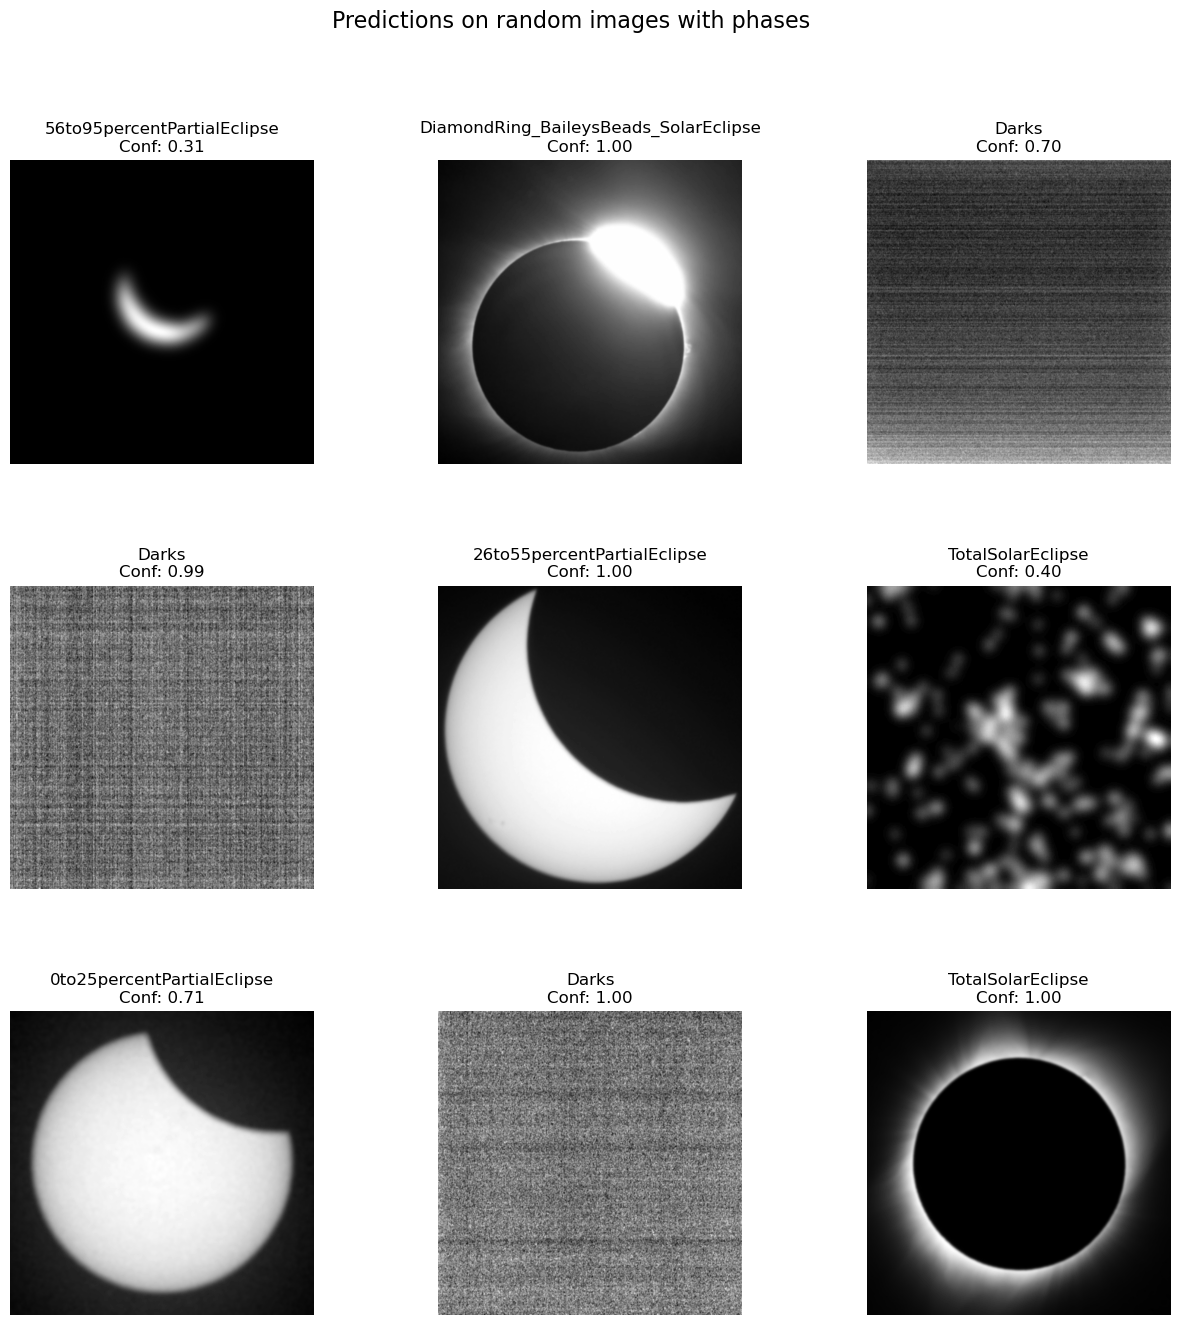

In [288]:
label_map_path = r"eclipse-megamovie/label_num_to_phase_map.json"

with open(label_map_path, "r") as file:
    label_num_to_phase_map = {v: k for k, v in json.load(file).items()}

def display_predictions(dataset, predictions, num_images=9):
    sample_preds = random.sample(predictions, min(num_images, len(predictions)))

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle("Predictions on random images with phases", fontsize=16)
    axes = axes.flatten()
    
    for ax, (img_name, label, confidence) in zip(axes, sample_preds):
        img_path = os.path.join(dataset.image_folder, img_name)
        image = Image.open(img_path)
        phase_description = label_num_to_phase_map.get(label, "Unknown")
        ax.imshow(image, cmap="gray")
        ax.set_title(f"{phase_description}\nConf: {confidence:.2f}")
        ax.axis("off")

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()

display_predictions(test_dataset, predictions)

# Histograms classification 

In [289]:
def gaussdx(sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    
    sigma = math.ceil(sigma)
    filter_size = 6 * sigma + 1

    zero_pos = filter_size //2
    x = np.arange(filter_size) - zero_pos

    Dx = (-x) * np.exp(-(x**2) / (2.0 * sigma**2)) / (math.sqrt(2.0 * np.pi) * sigma**3)

    return Dx, x

In [290]:
def gauss_dxdy(img: np.ndarray, sigma: float) -> Tuple[np.ndarray, np.ndarray]:
    
    Dx, _ = gaussdx(sigma)
    img_Dx = convolve1d(img, Dx, axis=1)
    img_Dy = convolve1d(img, Dx, axis=0)

    return img_Dx, img_Dy

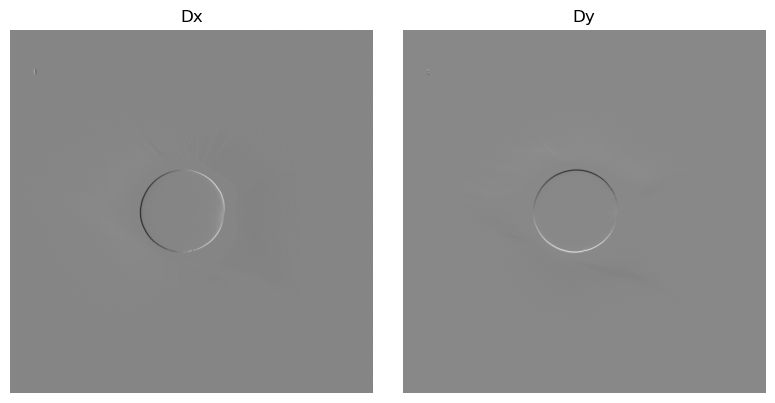

In [291]:
img_color = rgb2gray(np.array(Image.open("eclipse-megamovie/test/0083b50624b619bb66705581d5c08e6fc2dc77574a979835ef01f96f9f19f8b1.jpg")))

img_Dx, img_Dy = gauss_dxdy(img_color, 1)

plot_pictures([img_Dx, img_Dy], ["Dx", "Dy"], 1, 2)

In [292]:
def hist_dxdy(img_gray, num_bins=5):
    
    sigma = 3.0
    img_dx, img_dy = gauss_dxdy(img_gray, sigma)

    min_der, max_der = (-6, 6)

    img_dx = img_dx.reshape(-1)
    img_dy = img_dy.reshape(-1)
    
    img_dx = np.clip(img_dx, min_der, max_der) - min_der
    img_dy = np.clip(img_dy, min_der, max_der) - min_der

    hists = np.zeros((num_bins, num_bins), dtype=float)
    bin_range = (max_der - min_der) / num_bins

    bin_dx = np.floor(img_dx / bin_range).astype(int)
    bin_dy = np.floor(img_dy / bin_range).astype(int)
    bin_dx = np.clip(bin_dx, 0, num_bins - 1)
    bin_dy = np.clip(bin_dy, 0, num_bins - 1)

    for i in range(bin_dx.size):
        hists[bin_dx[i], bin_dy[i]] += 1

    hists /= hists.sum()
    hists = hists.flatten()
    return hists

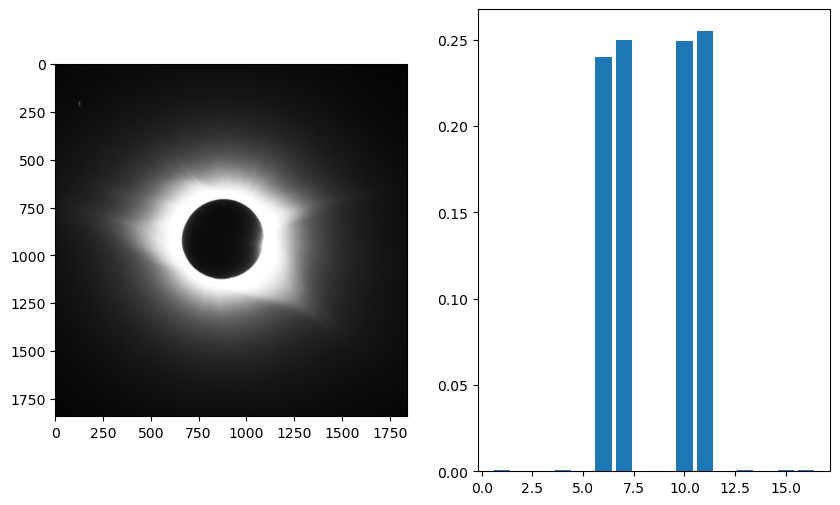

In [293]:
img_color = np.array(Image.open("eclipse-megamovie/test/0083b50624b619bb66705581d5c08e6fc2dc77574a979835ef01f96f9f19f8b1.jpg"))
img_gray = rgb2gray(img_color.astype("double"))

plt.figure(5, figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_gray)

num_bins_dxdy = 4
plt.subplot(1, 2, 2)
hist_dxdy_ = hist_dxdy(img_gray, num_bins_dxdy)
plt.bar(np.array(range(1, hist_dxdy_.size + 1)), hist_dxdy_)
plt.show()

In [294]:
def hist_intersect(h1: np.ndarray, h2: np.ndarray) -> float:
    
    min_sum = np.sum(np.minimum(h1, h2))
    x = 0.5 * (min_sum / np.sum(h1) + min_sum / np.sum(h2))
    
    return x

def hist_l2(h1: np.ndarray, h2: np.ndarray) -> float:
    
    x = (np.sqrt(np.sum((h1-h2)**2)))
    
    return x


def hist_chi2(h1: np.ndarray, h2: np.ndarray) -> float:

    eps = 1 
    x = np.sum((h1 - h2)**2 / (h1 + h2 + eps)) 
  
    return x


In [295]:
def is_grayvalue_hist(hist_name: str) -> bool:

    if hist_name == "grayvalue" or hist_name == "dxdy":
        return True
    elif hist_name == "rgb" or hist_name == "gb":
        return False
    else:
        assert False, "unknown histogram type"


def get_hist_by_name(img: np.ndarray, num_bins_gray: int, hist_name: str) -> np.ndarray:

    if hist_name == "dxdy":
        return hist_dxdy(img, num_bins_gray)
    else:
        assert False, "unknown hist type: %s" % hist_name


def get_dist_by_name(x: np.ndarray, y: np.ndarray, dist_name: str) -> float:

    if dist_name == "chi2":
        return hist_chi2(x, y)
    elif dist_name == "intersect":
        return 1 - hist_intersect(x, y)
    elif dist_name == "l2":
        return hist_l2(x, y)
    elif dist_name == "all":
        pass
    else:
        assert False, "unknown distance: %s" % dist_name
        
def write_files(folder_path, output_file):

    image_extensions = {".jpg", ".jpeg", ".png"}

    try:
        if not os.path.isdir(folder_path):
            print(f"Error: Folder {folder_path} does not exist.")
            return

        files = os.listdir(folder_path)
        image_files = [file for file in files if os.path.splitext(file)[1].lower() in image_extensions]
        with open(output_file, "w") as f:
            for image_name in image_files:
                f.write("train_preprocessed/" + image_name + "\n")

        print(f"List of images saved in {output_file}.")
    except Exception as e:
        print(f"An error occurred: {e}")

write_files("train_preprocessed","model.txt")
        

def read_files(
    model_path: str = "model.txt", query_path: str = "query.txt"
) -> Tuple[List[str], List[str]]:
    with open(model_path) as fp:
        model_images = fp.readlines()
    model_images = [x.strip() for x in model_images]

    with open(query_path) as fp:
        query_images = fp.readlines()
    query_images = [x.strip() for x in query_images]

    return query_images, model_images

List of images saved in model.txt.


In [296]:
def compute_histograms(
    image_list: List[np.ndarray], hist_type: str, hist_isgray: bool, num_bins: int
) -> List[np.ndarray]:

    image_hist = []
    for img in image_list:
        if hist_isgray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     
        img = img.astype(np.float32)
        if img.dtype != np.float32:
            raise ValueError(f"Image dtype is {img.dtype}, expected float32.")

        hist = get_hist_by_name(img, num_bins, hist_type)
        image_hist.append(hist)

    return image_hist


def find_best_match(
    train_images: List[str],
    dist_type: str,
    hist_type: str,
    num_bins: int,
) -> Tuple[np.ndarray, np.ndarray]:

    train_imgs = [cv2.imread(img) for img in train_images]

    hist_isgray = is_grayvalue_hist(hist_type)
    train_hist = compute_histograms(train_imgs, hist_type, hist_isgray, num_bins)

    D = np.zeros((len(train_imgs), len(train_imgs)))

    for i, m in enumerate(train_hist):
        for j, q in enumerate(train_hist):
            if i == j:
                continue
            dist_value = get_dist_by_name(m, q, dist_type)
            D[i, j] = dist_value

    return D


In [297]:
query_images, model_images = read_files()

dist_type = "intersect"
hist_type = "dxdy"
num_bins = 16

df = pd.read_csv("eclipse-megamovie/train.csv")
y_true = df["label"].to_numpy()

D = find_best_match(
 model_images, dist_type, hist_type, num_bins
)

In [298]:
def show_neighbors(
    train_images: List[str],
) -> None:

    for i in range(0,5):
        sorted_indices = np.argsort(D[:, i])[:5]
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 6, 1)
        query_img = plt.imread(train_images[i])
        plt.imshow(query_img)
        plt.title('Training image')
        plt.axis('off')

        for idx, j in enumerate(sorted_indices):
            if j == i:
                continue
            plt.subplot(1, 6, idx + 2)
            img = plt.imread(train_images[j])
            plt.imshow(img)
            matching_value = D[j, i]
            plt.title(f' {matching_value:.4f}')
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [299]:
def calculate_label(
    train_images: List[str],
    D: np.ndarray,
    csv_file: str
) -> Tuple[Dict[str, str], Dict[str, str]]:

    df = pd.read_csv(csv_file)
    label_dict = {os.path.basename(row['image_id']): row['label'] for index, row in df.iterrows()}

    y_true = {}
    y_pred = {}

    for i in range(len(train_images)):
        sorted_indices = np.argsort(D[:, i])
        query_img_name = os.path.basename(train_images[i])
        query_label = label_dict.get(query_img_name, "Unknown")
        y_true[query_img_name] = query_label

        closest_idx = sorted_indices[1]
        closest_img_name = os.path.basename(train_images[closest_idx])
        closest_img_label = label_dict.get(closest_img_name, "Unknown")

        y_pred[query_img_name] = closest_img_label

    return y_true, y_pred

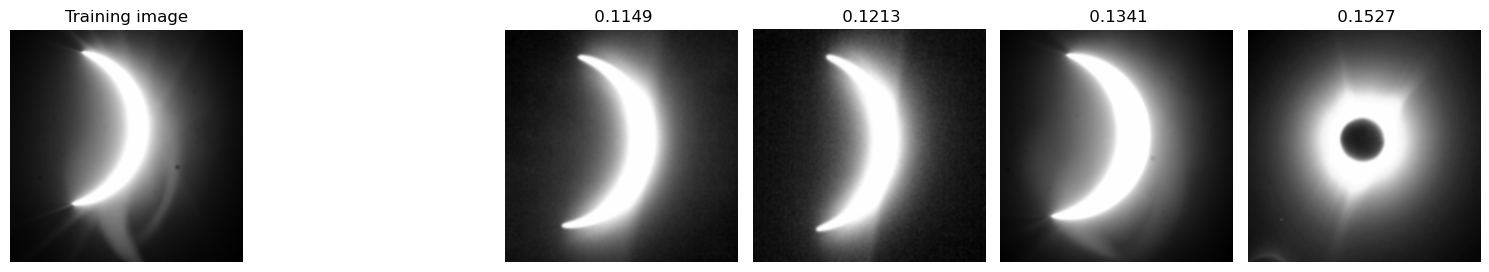

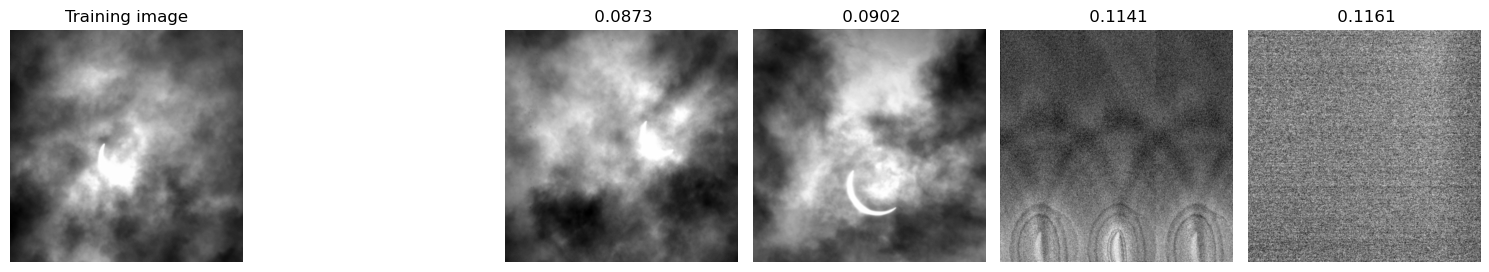

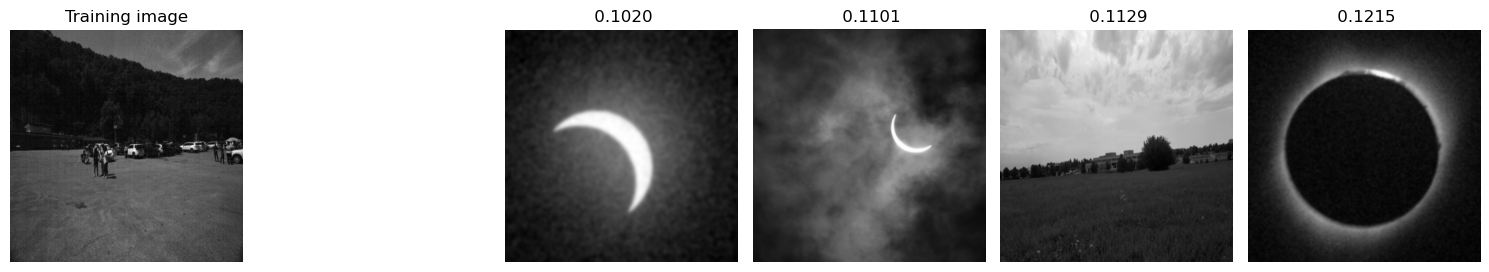

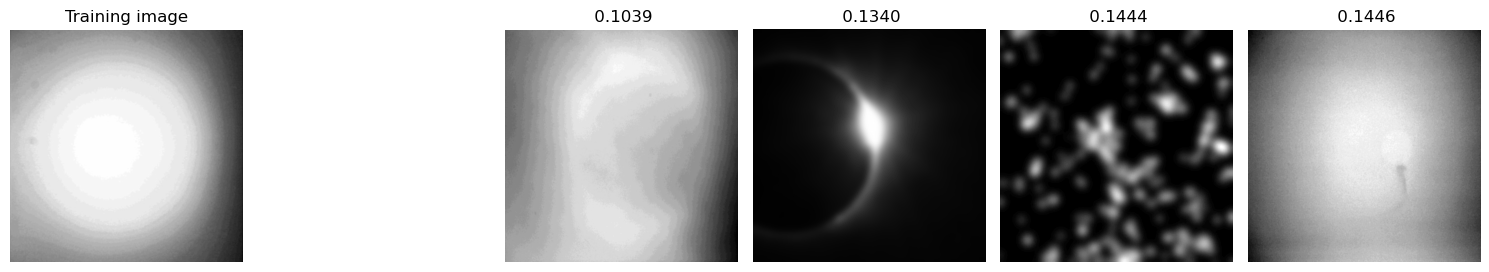

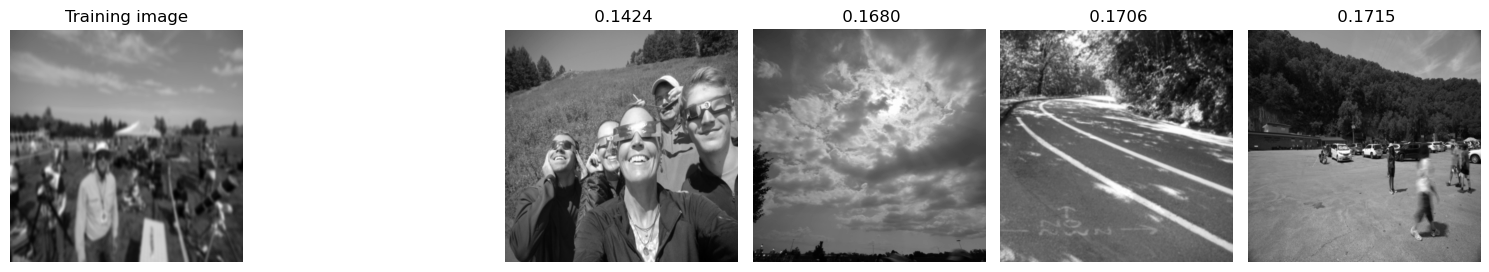

In [300]:
query_images_vis = [model_images[i] for i in np.array([1, 2])]

show_neighbors(model_images)
y_pred, y_true =  calculate_label(model_images,D,"eclipse-megamovie/train.csv")

In [301]:
def calculate_accuracy(y_true, y_pred):
    correct = 0
    total = 0
    
    for key in y_true:
        if key in y_pred:
            total += 1
            if y_true[key] == y_pred[key]:
                correct += 1
    
    accuracy = correct / total if total > 0 else 0
    return accuracy

In [302]:
accuracy = calculate_accuracy(y_true,y_pred)
accuracy = accuracy * 100 
print(f"Accuracy: {accuracy: .2f}%")

Accuracy:  76.36%


### Metrics report


----------------------------
|  | Number of Bins | Metric(Distance Metric) | Accuracy(%) |
|---|---|---|---|
| 1 | 2 | Intersect | 47.87 |
| 2 | 4 | Intersect | 65.85 |
| 3 | 8 | Intersect | 72.32 |
| 4 | 16 | Intersect | 76.36 |
| 5 | 32 | Intersect | 76.36 |
| 6 | 2 | L2 | 49.09 |
| 7 | 4 | L2 | 63.43 |
| 8 | 8 | L2 | 68.48 |
| 9 | 16 | L2 | 70.71 |
| 10 | 32 | L2 | 70.10 |
| 11 | 2 | Chi2 | 49.09 |
| 12 | 4 | Chi2 | 64.04 |
| 13 | 8 | Chi2 | 69.49 |
| 14 | 16 | Chi2 | 71.72 |
| 15 | 32 | Chi2 | 71.52 |

---